# モデリング

In [2]:
# 1. ライブラリのインポート
# vscodeで実行する場合にはipykernelパッケージが必要

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# warningsを無視する
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# 2. グラフの設定

plt.style.use('fast') # スタイルの設定
plt.rcParams['figure.figsize'] = [9, 5] # サイズの設定

In [4]:
# 3. DataFrameの作成

file_path = "../data/BloodDonation.csv"
df = pd.read_csv(file_path)

# date 列を作成
df['date'] = pd.to_datetime((df['year'].astype(str)) + '-' + (df['month'].astype(str)))

# date ごとの全国の blood_donors でグループ化
grouped_date_total = df.groupby(['date'])['blood_donors'].sum().to_frame()
grouped_date_total.head()

,blood_donors
date,
2017-01-01,406899
2017-02-01,390045
2017-03-01,411315
2017-04-01,390606
2017-05-01,402952


### 時系列分析

外部の説明変数が乏しいため、過去の同じ変数の値を説明変数として扱う**時系列分析**を行う。
本分析では `blood_donors` という1つの変数を対象にし、過去の献血者数の推移から予測を行うことにする。これは、変数が時間と共に自己回帰的に変化すると仮定するアプローチ。このことからSARIMAモデルを使用する。

### SARIMAモデル

- モデルの選定理由
  - [年ごとの総献血者数の推移](./analyze.ipynb)より献血者数には季節性が見られる
  - トレンドや周期性、突発的な変動を同時にモデル化したい
  - 外部説明変数を持たず、単一の時系列で予測を行いたい

- モデル概要
  
    **SARIMA(p,d,q)(P,D,Q,s)**

  | 要素         | 説明                                           |
  |--------------|------------------------------------------------|
  | p (AR)       | 現在の値が過去の値のどれだけに依存するかを表す**自己回帰** |
  | d (I)        | 時系列データを定常化する回数を表す**和分**             |
  | q (MA)       | 過去の誤差が将来の値にどれだけ影響するかを表す**移動平均** |

In [5]:
# 学習データとテストデータ（直近12ヶ月間）に分割
train_size = len(grouped_date_total) - 12
df_train = grouped_date_total.iloc[:train_size]

# SARIMAモデルの自動パラメータ探索
smodel = pm.auto_arima(
    df_train,
    start_p=0, start_q=0, max_p=4, max_q=4,
    seasonal=True, m=12, start_P=0, start_Q=0,
    max_P=4, max_Q=4, d=1, D=1, trace=True,
    error_action='ignore', suppress_warnings=True,
    stepwise=True
)

# 選択されたモデルのサマリー
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1623.592, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1625.203, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1629.073, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1623.843, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1623.253, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1623.429, Time=0.21 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1624.998, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1631.474, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1625.226, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.682 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. O

c:\PJD\products\kenketsu-navi\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\PJD\products\kenketsu-navi\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


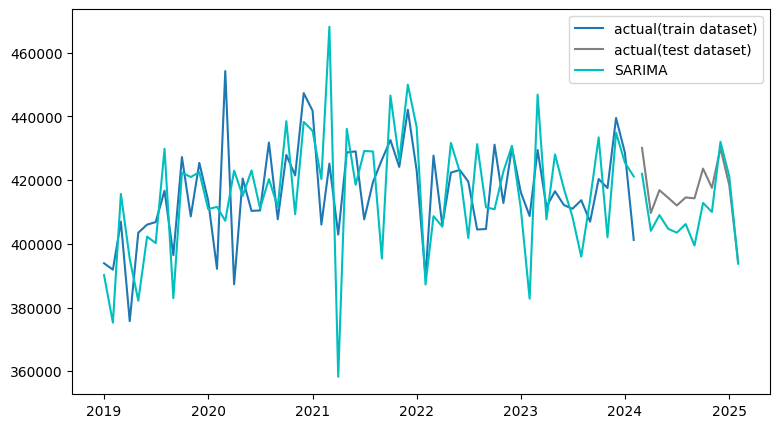

In [6]:
# 学習データとテストデータ（直近12ヶ月間）に分割
df_train, df_test = model_selection.train_test_split(grouped_date_total, test_size=12)

# 原系列を学習データとする
train = df_train

# 学習
sarima_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()

# 予測
#学習データの期間の予測値
train_pred = sarima_fit.predict()
#テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
#予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 

# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
# ax.fill_between(df_test.index, test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='c', alpha=.2)
ax.legend()
plt.show()

In [7]:
# テストデータで精度検証
print('RMSE: ',np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE: ',mean_absolute_error(df_test, test_pred)) 
print('MAPE: ',mean_absolute_percentage_error(df_test, test_pred))

print(sarima_fit.summary())

RMSE:  8166.7896283260125
MAE:  7217.833333333333
MAPE:  0.01729877462081982
                                     SARIMAX Results                                      
Dep. Variable:                       blood_donors   No. Observations:                   86
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -810.796
Date:                            Tue, 15 Apr 2025   AIC                           1623.592
Time:                                    18:13:08   BIC                           1625.883
Sample:                                01-01-2017   HQIC                          1624.505
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.292e+08   2.81e+07     

RMSE:予測誤差の二乗平均の平方根<br>
MAE:予測誤差の絶対値の平均<br>
MAPE:予測誤差の割合の絶対値の平均<br>

増加・減少の傾向はある程度とらえることができているのでは

#### 参考にしたサイト等
https://momonoki2017.blogspot.com/2018/03/python9sarima.html<br>
https://www.salesanalytics.co.jp/datascience/datascience087/#pdq_PDQm<br>
https://qiita.com/KENTAROSZK/items/a8d25122a9659967d9f4<br>
https://blog.since2020.jp/data_analysis/arima%E3%83%A2%E3%83%87%E3%83%AB%E3%81%A7%E6%99%82%E7%B3%BB%E5%88%97%E4%BA%88%E6%B8%AC%E3%82%92%E3%82%84%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%8B/<br>
